In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


After mounting your drive, you can navigate to the directory where your notebook and script are located. For example, if your notebook is directly in 'My Drive' in a folder called 'Colab Notebooks', and your script `my_script.py` is there, you would use:

```python
%cd /content/drive/MyDrive/Colab Notebooks
!python my_script.py
```

**Please replace `/content/drive/MyDrive/Colab Notebooks` with the actual path to your notebook's directory, and `my_script.py` with the actual name of your Python script.**

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Projects

# Run it and watch progress bars tick by
!python data_generation.py

# This will:
# - Generate 5000 random smooth potentials
# - Solve the Schrödinger equation for each one
# - Save everything to schrodinger_training_data.h5
# - Create visualizations for verification



/content/drive/MyDrive/Colab Notebooks/Projects
Generating 5000 Schrödinger equation solutions...
Grid points: 256, Eigenstates: 4
Enjoy.

100% 5000/5000 [00:05<00:00, 930.76it/s]

Saving to schrodinger_training_data.h5...
✓ Dataset saved successfully!
  File size: 51.4 MB
  Training samples: 5000
  Validation examples: 5 Griffiths classics
Sample visualization saved to sample_potentials.png
Figure(1600x800)

Data generation complete!

Next steps:
1. Verify the visualizations look reasonable
2. Train your FNO on this data


# Sanity Check

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks/Projects/Schrodinger NO

/content/drive/MyDrive/Colab Notebooks/Projects/Schrodinger NO


In [ ]:
# Quick sanity checks
import h5py
import numpy as np

with h5py.File('schrodinger_training_data.h5', 'r') as f:
    V = f['potentials'][:]
    E = f['energies'][:]
    psi = f['wavefunctions'][:]

    # Check for duplicates
    print(f"Unique potentials: {len(np.unique(V, axis=0))}/{len(V)}")

    # Energy statistics
    print(f"Energy range: [{E.min():.2f}, {E.max():.2f}]")
    print(f"Mean energy spacing: {np.diff(E, axis=1).mean():.2f}")

    # Orthogonality check (ψ should be orthogonal)
    sample_idx = 100
    overlaps = []
    for i in range(4):
        for j in range(i+1, 4):
            overlap = np.abs(np.sum(psi[sample_idx, i] * psi[sample_idx, j]))
            overlaps.append(overlap)
    print(f"Max orthogonality violation: {max(overlaps):.6f}")
    # (should be ~0, but finite differences aren't perfect)

Unique potentials: 5000/5000
Energy range: [-26072.05, 24.88]
Mean energy spacing: 12.03
Max orthogonality violation: 0.000000


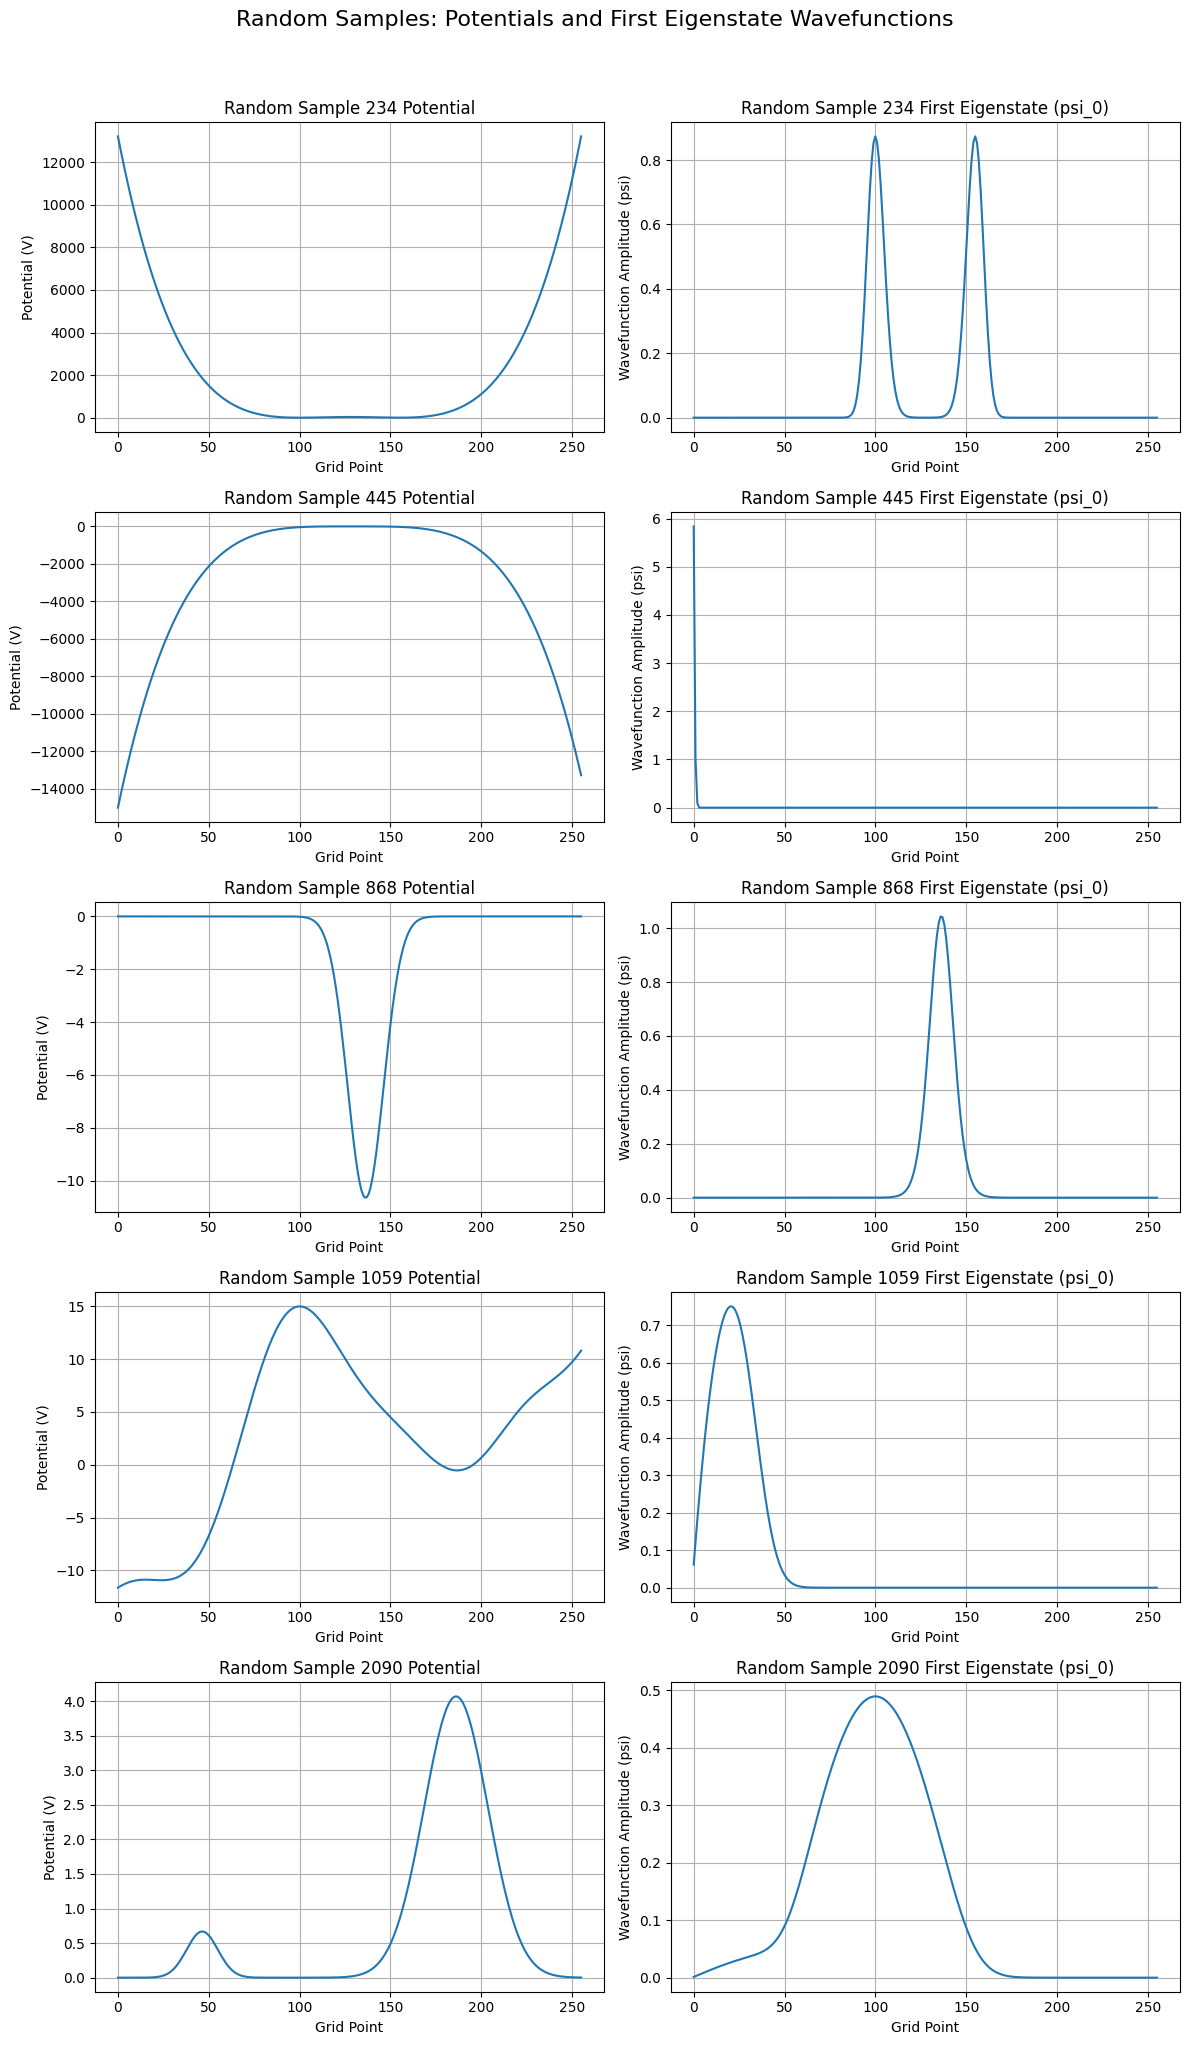

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

with h5py.File('schrodinger_training_data.h5', 'r') as f:
    V = f['potentials'][:]
    psi = f['wavefunctions'][:]

    num_samples_to_plot = 5

    # Generate 5 random indices from the available samples
    random_indices = np.random.choice(len(V), num_samples_to_plot, replace=False)

    fig, axes = plt.subplots(num_samples_to_plot, 2, figsize=(12, 4 * num_samples_to_plot))
    fig.suptitle('Random Samples: Potentials and First Eigenstate Wavefunctions', y=1.02, fontsize=16)

    for i, idx in enumerate(random_indices):
        # Plot Potential
        axes[i, 0].plot(V[idx])
        axes[i, 0].set_title(f'Random Sample {idx+1} Potential')
        axes[i, 0].set_xlabel('Grid Point')
        axes[i, 0].set_ylabel('Potential (V)')
        axes[i, 0].grid(True)

        # Plot First Eigenstate Wavefunction
        axes[i, 1].plot(psi[idx, 0])
        axes[i, 1].set_title(f'Random Sample {idx+1} First Eigenstate (psi_0)')
        axes[i, 1].set_xlabel('Grid Point')
        axes[i, 1].set_ylabel('Wavefunction Amplitude (psi)')
        axes[i, 1].grid(True)

    plt.tight_layout()
    plt.show()

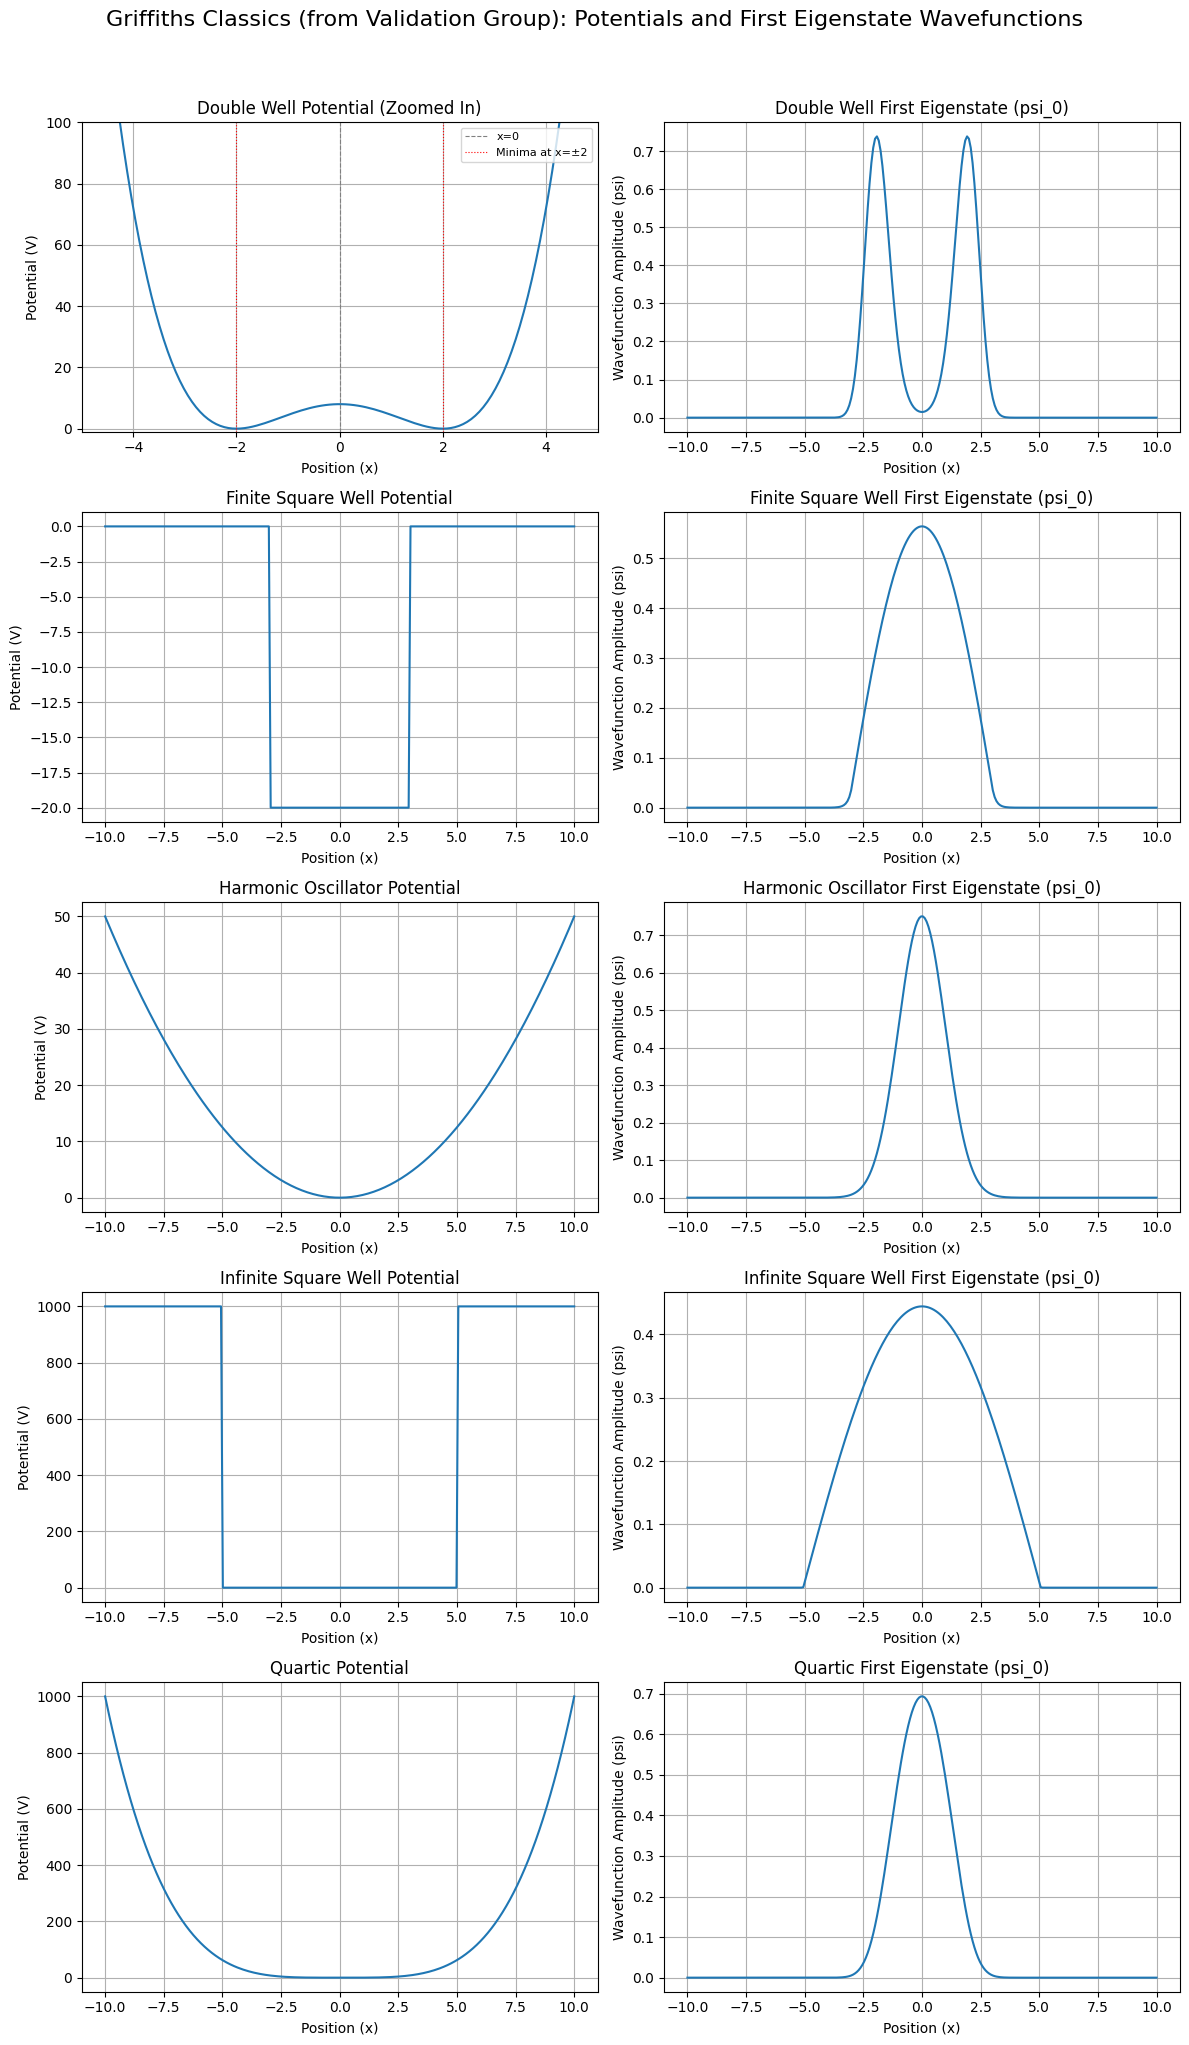

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Re-initialize the generator to get the x_grid
class SchrodingerDataGenerator:
    def __init__(
        self,
        n_points=256,
        x_min=-10.0,
        x_max=10.0,
        n_eigenstates=4,
        hbar=1.0,
        mass=1.0
    ):
        self.n_points = n_points
        self.x = np.linspace(x_min, x_max, n_points)
        self.dx = self.x[1] - self.x[0]
        self.n_eigenstates = n_eigenstates
        self.hbar = hbar
        self.mass = mass

# Create an instance to get the x-grid
generator_for_x = SchrodingerDataGenerator()
x_grid = generator_for_x.x

with h5py.File('schrodinger_training_data.h5', 'r') as f:
    # Access the 'validation' group
    validation_group = f['validation']

    # Get the names of the classic potentials
    classic_names = list(validation_group.keys())
    num_validation_examples = len(classic_names)

    fig, axes = plt.subplots(num_validation_examples, 2, figsize=(12, 4 * num_validation_examples))
    fig.suptitle('Griffiths Classics (from Validation Group): Potentials and First Eigenstate Wavefunctions', y=1.02, fontsize=16)

    for i, name in enumerate(classic_names):
        # Access potential and wavefunctions from the specific classic subgroup
        V_classic = validation_group[name]['potential'][:]
        psi_classic = validation_group[name]['wavefunctions'][:]

        # Plot Potential
        axes[i, 0].plot(x_grid, V_classic)
        axes[i, 0].set_title(f'{name.replace("_", " ").title()} Potential')
        axes[i, 0].set_xlabel('Position (x)')
        axes[i, 0].set_ylabel('Potential (V)')
        axes[i, 0].grid(True)

        # Apply zoom for double_well potential for better visualization
        if name == 'double_well':
            axes[i, 0].set_ylim(-1, 100) # Adjust these limits as needed to clearly see the wells and barrier
            axes[i, 0].set_xlim(-5, 5)  # Also limit x-axis for better focus
            axes[i, 0].axvline(x=0, color='gray', linestyle='--', linewidth=0.8, label='x=0')
            axes[i, 0].axvline(x=-2, color='red', linestyle=':', linewidth=0.8, label='Minima at x=±2')
            axes[i, 0].axvline(x=2, color='red', linestyle=':', linewidth=0.8)
            axes[i, 0].legend(loc='upper right', fontsize=8)
            axes[i, 0].set_title(f'{name.replace("_", " ").title()} Potential (Zoomed In)') # Update title for clarity

        # Plot First Eigenstate Wavefunction
        # Assuming the first eigenstate is at index 0 of the wavefunction array
        axes[i, 1].plot(x_grid, psi_classic[0])
        axes[i, 1].set_title(f'{name.replace("_", " ").title()} First Eigenstate (psi_0)')
        axes[i, 1].set_xlabel('Position (x)')
        axes[i, 1].set_ylabel('Wavefunction Amplitude (psi)')
        axes[i, 1].grid(True)

    plt.tight_layout()
    plt.show()